# [Marketing Campaign Analysis & Classification to a Term Deposit](https://archive.ics.uci.edu/ml/datasets/bank+marketing):

## Data:

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [1]:
# Importing required Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['patch.force_edgecolor'] = True
plt.autoscale(enable=True, axis='both', tight=True)

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from yellowbrick.classifier import ClassificationReport #pip install yellowbrick --user

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Exploratory Data Analysis:

In [2]:
data = pd.read_csv('D:/CRITICAL/New_Desktop/bank/bank.csv', sep=';')
data = data.dropna()
print(f'Data is of shape {data.shape}!')
data.columns

Data is of shape (4521, 17)!


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [3]:
data.tail(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4511,46,blue-collar,married,secondary,no,668,yes,no,unknown,15,may,1263,2,-1,0,unknown,yes
4512,40,blue-collar,married,secondary,no,1100,yes,no,unknown,29,may,660,2,-1,0,unknown,no
4513,49,blue-collar,married,secondary,no,322,no,no,cellular,14,aug,356,2,-1,0,unknown,no
4514,38,blue-collar,married,secondary,no,1205,yes,no,cellular,20,apr,45,4,153,1,failure,no
4515,32,services,single,secondary,no,473,yes,no,cellular,7,jul,624,5,-1,0,unknown,no
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


**Target Variable:**
`y` has the outcome of whether client subscribed to a term deposit or not.

In [4]:
# Checking feature datatypes:
data.dtypes

# Binarizing 'y' feature:
data['y'] = data.y.map({'no': 0, 'yes': 1})
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,0
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,0
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,0
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,0
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,0


In [5]:
print(f"Available values in Target variable are: {list(data['y'].unique())}. \nNote that we've fetched smaller bank data to keep our process less computationally exhaustive.")
data['y'].value_counts()

Available values in Target variable are: [0, 1]. 
Note that we've fetched smaller bank data to keep our process less computationally exhaustive.


0    4000
1     521
Name: y, dtype: int64

## Visual representation for better insight:

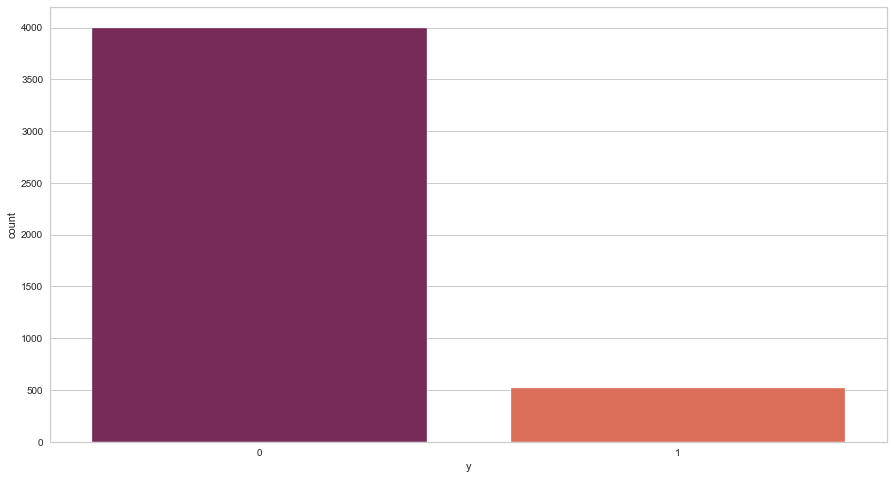

In [6]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.countplot(x='y', data=data, palette='rocket')

There are **4000** `no` and **521** `yes` in the outcome `y` variable.
Let's get a sense of the numbers across these two classes:

In [7]:
data.groupby('y').mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
0,40.998000,1403.211750,15.948750,226.347500,2.862250,36.006000,0.471250
1,42.491363,1571.955854,15.658349,552.742802,2.266795,68.639155,1.090211


**Observations:**

The average `age` of customers who bought the *term deposit* is higher than that of the customers who didn't, though not a major differentiating factor. The `pdays` (days since the customer was last contacted) is understandably lower for the customers who bought it. Lower the `pdays`, better the memory of last telephonic interaction, and hence comparatively better chances of a sale. Surprisingly, `campaign` (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [8]:
data.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous,y
job,,,,,,,,
admin.,39.682008,1226.736402,16.324268,234.669456,2.631799,49.993724,0.644351,0.121339
blue-collar,40.156448,1085.161734,15.482030,278.161734,2.846723,41.590909,0.493658,0.072939
entrepreneur,42.011905,1645.125000,15.255952,285.476190,2.589286,32.273810,0.428571,0.089286
housemaid,47.339286,2083.803571,15.294643,292.633929,2.500000,26.401786,0.357143,0.125000
management,40.540764,1766.928793,16.254902,260.536636,2.973168,40.968008,0.549020,0.135191
retired,61.869565,2319.191304,15.556522,285.656522,2.465217,35.073913,0.591304,0.234783
self-employed,41.453552,1392.409836,16.180328,264.125683,3.278689,28.256831,0.590164,0.109290
services,38.570743,1103.956835,15.515588,262.486811,2.822542,36.371703,0.443645,0.091127
student,26.821429,1543.821429,16.392857,248.690476,2.392857,45.714286,0.964286,0.226190


In [9]:
data.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous,y
marital,,,,,,,,
divorced,45.475379,1122.390152,15.753788,279.232955,2.604167,38.827652,0.439394,0.145833
married,43.454415,1463.195567,15.905971,256.528781,2.847336,38.466929,0.519128,0.099035
single,33.927258,1460.414716,16.008361,274.601171,2.751672,43.220736,0.642977,0.139632


In [10]:
data.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous,y
education,,,,,,,,
primary,46.833333,1411.544248,15.505900,261.709440,2.865782,35.069322,0.460177,0.094395
secondary,40.062446,1196.814397,15.977884,269.863833,2.734172,40.934085,0.528621,0.106245
tertiary,39.645926,1775.423704,16.009630,256.881481,2.901481,39.824444,0.612593,0.142963
unknown,45.299465,1701.245989,15.946524,250.449198,2.486631,41.983957,0.508021,0.101604


Text(0, 0.5, 'Frequency of Purchase')

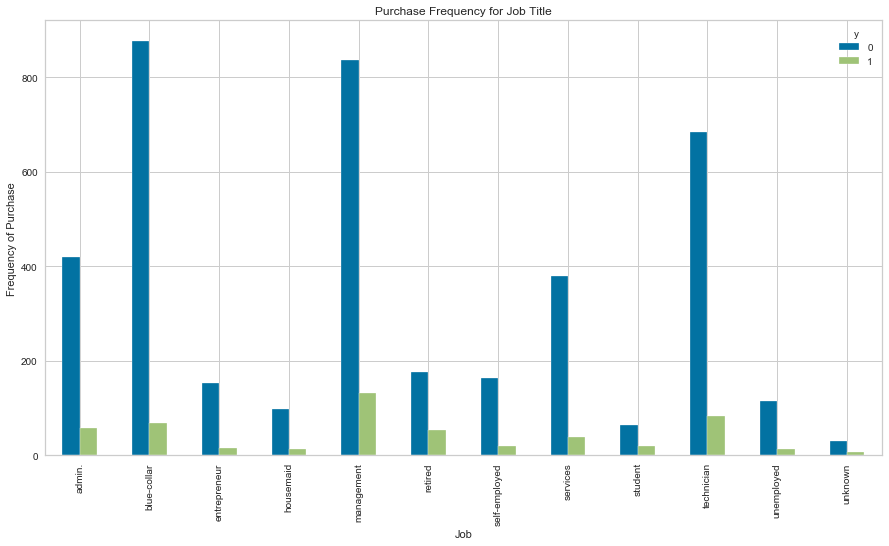

In [11]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

The *frequency of purchase* of the deposit depends a great deal on the `job` title. Thus, the `job` title can be a good predictor for our target variable.

Let's similarly check rest or few of other parameters:

Text(0, 0.5, 'Proportion of Customers')

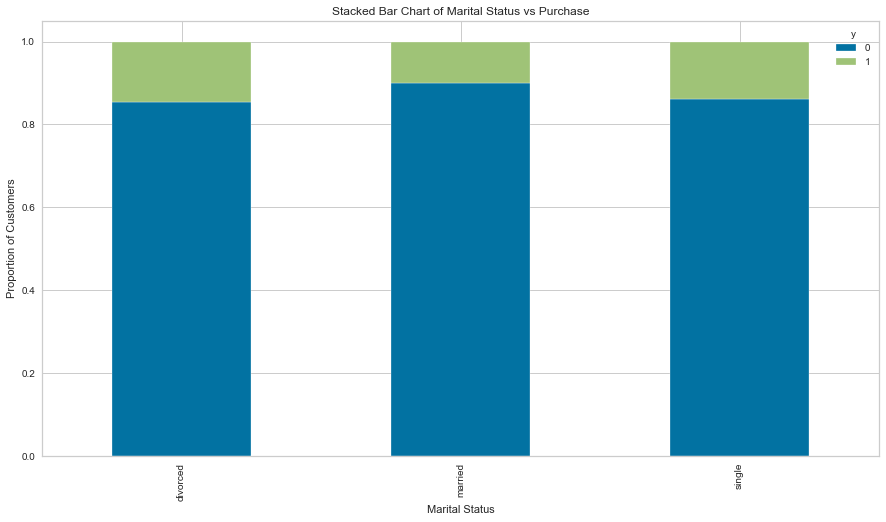

In [12]:
table= pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

`marital` status does not seem to be a strong indicator here.

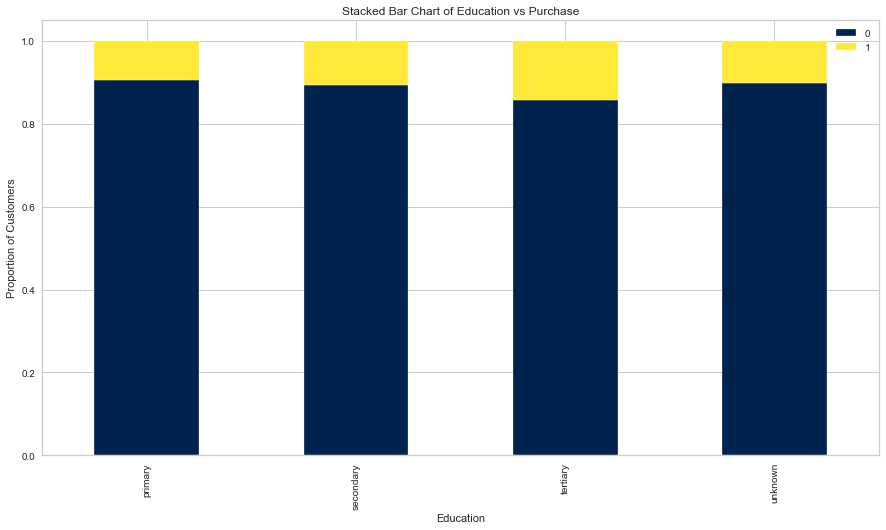

In [13]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, colormap='cividis')
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.legend(loc='top right')

Education seems a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Purchase')

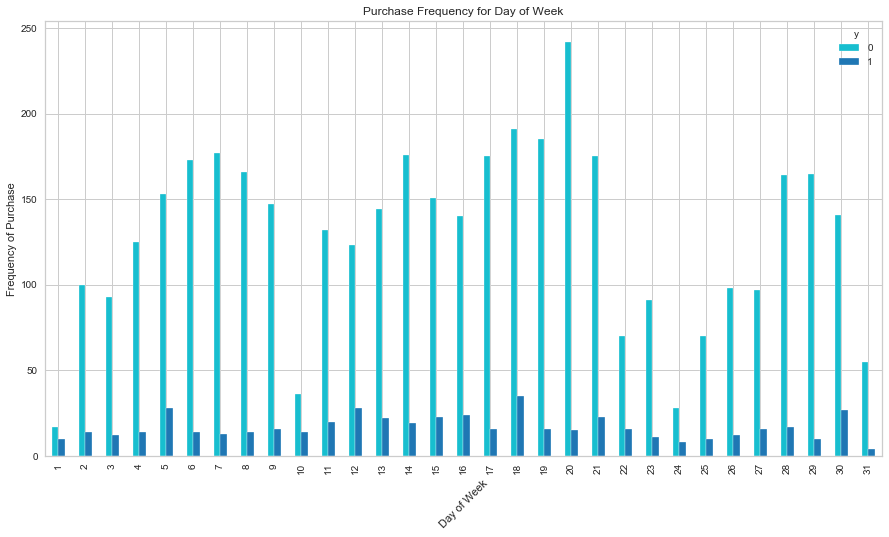

In [14]:
pd.crosstab(data.day,data.y).plot(kind='bar',colormap='tab10_r')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week', rotation=45)
plt.ylabel('Frequency of Purchase')

Doesn't look like a great predictor!

Text(0, 0.5, 'Frequency of Purchase')

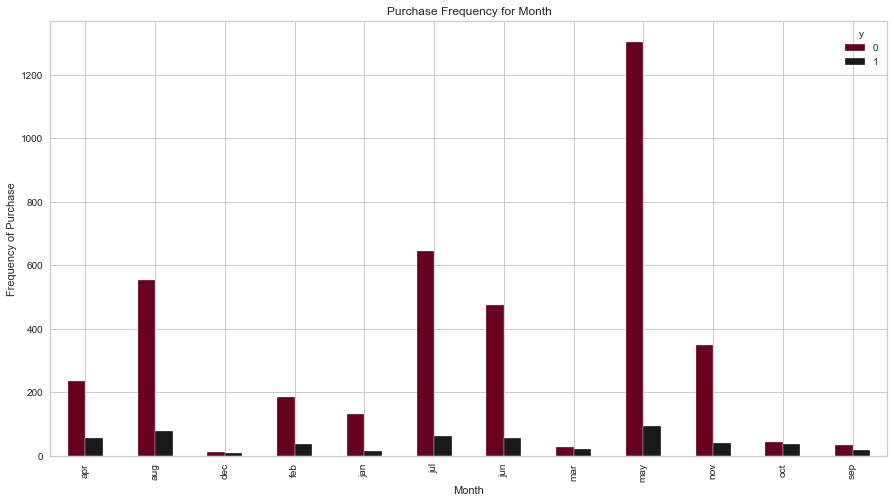

In [15]:
pd.crosstab(data.month,data.y).plot(kind='bar', colormap='RdGy')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency')

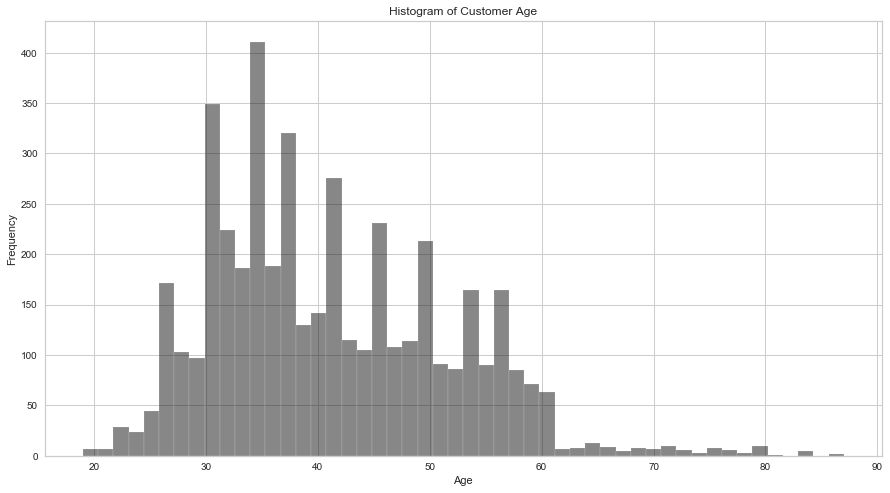

In [16]:
data.age.hist(color='k', alpha=0.5, bins=50)
plt.title('Histogram of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Most of the customers of the bank in this dataset are in the `age` range of **30-40**.

Text(0, 0.5, 'Frequency of Purchase')

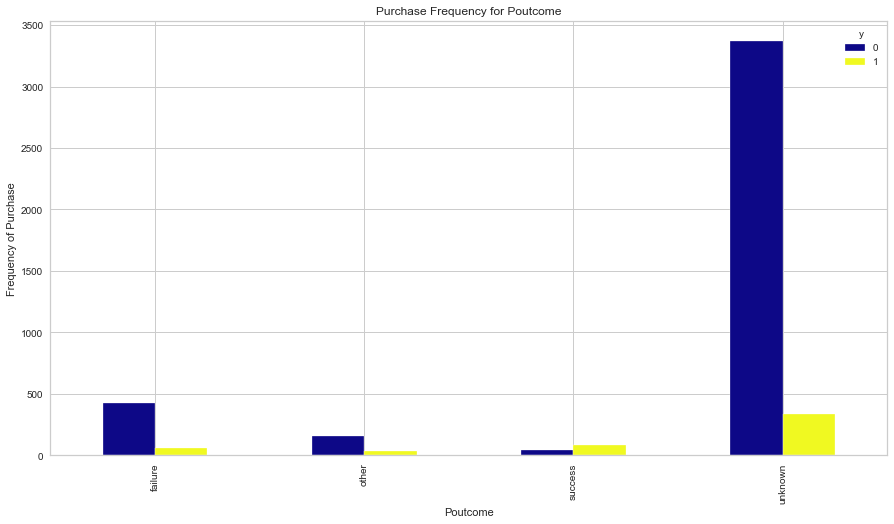

In [17]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar',colormap='plasma')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

`poutcome` seems to be a good predictor of our target variable.

## One-hot encoding Categorical variables:

In [18]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day','poutcome']

for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1 = data.join(cat_list)
    data = data1

In [19]:
data_vars= data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

final_data = data[to_keep]
final_data.columns.values


final_data_vars = final_data.columns.values.tolist()
y = ['y']
X = [i for i in final_data_vars if i not in y]

## Feature Selection:

In [20]:
logreg = LogisticRegression()

rfe = RFE(logreg, 18)
rfe = rfe.fit(final_data[X], final_data[y])
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False  True False False  True False False
 False False  True  True False  True  True False  True False  True False
 False False False False  True False False  True False False False False
 False False False False  True  True False False False  True False False
 False False  True False False  True False  True  True]
[60 64 61 47 63 59 31 21 57 43 56  1 58 30 15 25 17 12 23  6 52 32 51 50
 13 14 54 49 28 44  1 26 27  1 53  9 62 24  1  1 40  1  1  8  1 41  1 10
 45  3 35  4  1  7 48  1 46 16 29 11 37 34  2 19  1  1 20 33 36  1 39 42
 38 55  1 18  5  1 22  1  1]


In [21]:
cols=["job_management", "loan_no", "contact_telephone","month_feb","month_jan","month_jun","month_mar","month_nov","month_sep",
      "day_6","day_9","day_19","day_18","day_23","day_28","day_31","poutcome_other","poutcome_success"] 
X = final_data[cols]
y = final_data['y']

## Model Implementation:

In [22]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.385555
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4521
Model:                          Logit   Df Residuals:                     4503
Method:                           MLE   Df Model:                           17
Date:                Fri, 01 Mar 2019   Pseudo R-squ.:                -0.07898
Time:                        22:58:03   Log-Likelihood:                -1743.1
converged:                       True   LL-Null:                       -1615.5
                                        LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
job_management       -0.2686      0.110     -2.435      0.015      -0.485      -0.052
loan_no 

The **p-value** for majority is observed comparitively small enough.

## Logistic Regression Model Fitting:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

**Predicting test set results to further compute Accuracy:**

In [24]:
y_pred = logmodel.predict(X_test)

print(f"Accuracy of our Logistic Regression Classifier on test dataset: {logmodel.score(X_test, y_test): .2f}")

Accuracy of our Logistic Regression Classifier on test dataset:  0.88


## Applying k-fold Cross Validation:

In [25]:
kfold = KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print(f"Resultant 10-fold cross-validation average accuracy: {results.mean(): .3f}.")

Resultant 10-fold cross-validation average accuracy:  0.897.


## Scoring Metrics:

In [26]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[973  17]
 [120  21]]


The **Confusion matrix** tells us we a have total of 139 (121 + 18) misclassified values to Term Deposit subscription.

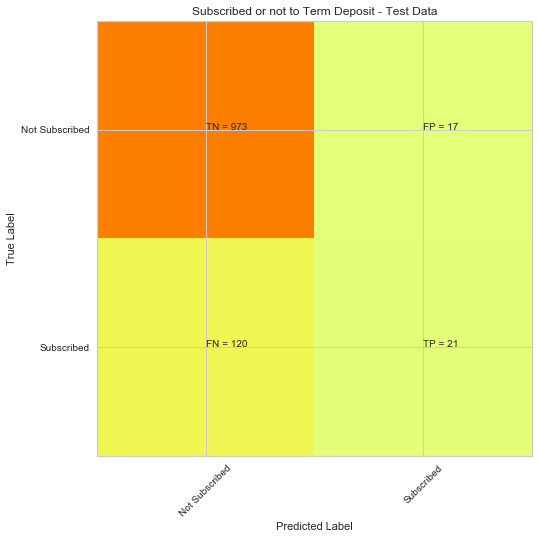

In [27]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Not Subscribed','Subscribed']
plt.title('Subscribed or not to Term Deposit - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       990
           1       0.55      0.15      0.23       141

   micro avg       0.88      0.88      0.88      1131
   macro avg       0.72      0.57      0.58      1131
weighted avg       0.85      0.88      0.85      1131



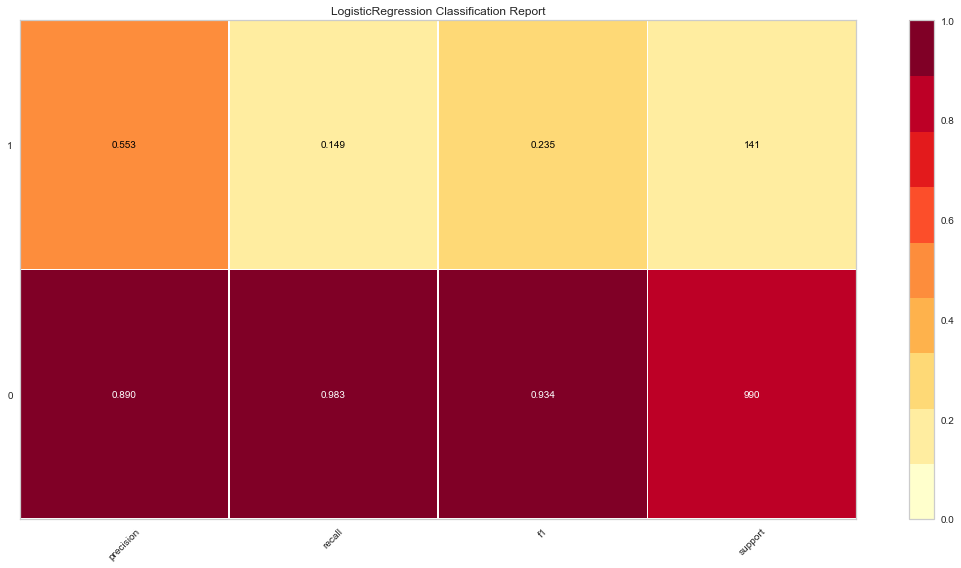

In [29]:
visualizer = ClassificationReport(logmodel, classes=[0,1], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

**Precision** is the ratio of **TP / (TP + FP)**, where TP is the number of true positives and FP the number of false positives. Precision is intuitively the ability of a classifier not to label a sample as positive, that is actually negative.

**Recall** is the ratio **TP / (TP + FN)**, where TP is the number of true positives and FN the number of false negatives. Recall is intuitively the ability of a classifier to find all the positive samples.

**F-beta score** can be interpreted as a **weighted harmonic mean of the Precision and Recall**, where an F-beta score reaches its best value at 1 and worst score at 0. F-beta score weighs recall more than precision by a factor of beta. `beta==1.0` means recall and precision are equally important.

**Support** is the **number of occurrences** of each Target class in `y_test`.

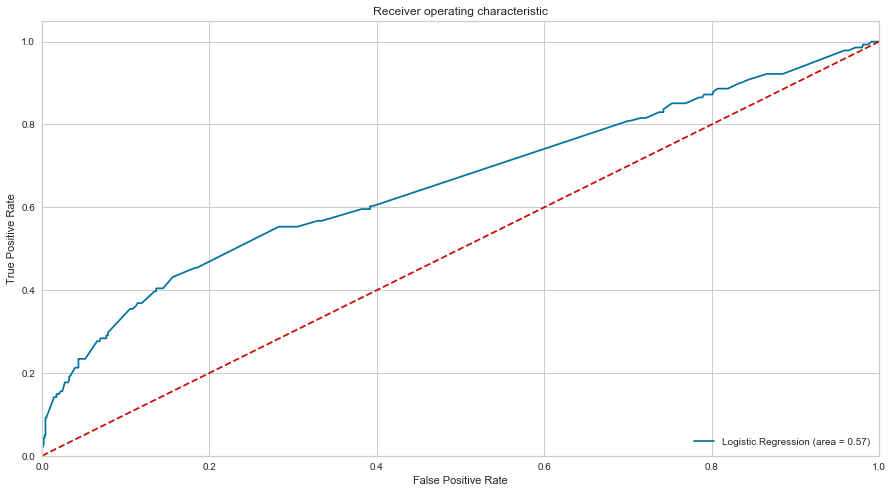

In [30]:
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')